In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os

In [3]:
base_dir="/content/drive/MyDrive/TESS Toronto emotional speech set data"

In [4]:
def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path)

    # Extract features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft, axis=1)

    fft = np.fft.fft(y)
    fft_mean = np.mean(np.abs(fft))

    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    mfccs_mean = np.mean(mfccs, axis=1)

    spectrogram = librosa.amplitude_to_db(librosa.stft(y))
    spectrogram_mean = np.mean(spectrogram, axis=1)

    # Concatenate features
    features = np.concatenate((chroma_stft_mean, [fft_mean], mfccs_mean, spectrogram_mean))

    return  chroma_stft,fft_mean,mfccs_mean,spectrogram_mean

In [5]:
data =[]

In [6]:
for class_dir in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_dir)
    if os.path.isdir(class_path):
        # Loop through each audio file in the class directory
        for file_name in os.listdir(class_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_path, file_name)
                chroma_stft,fft_mean,mfccs_mean,spectrogram_mean = extract_features(file_path)
                # Combine the file name, class, and features into one row
                row = [file_name, class_dir, chroma_stft,fft_mean,mfccs_mean,spectrogram_mean]
                data.append(row)

<ipython-input-4-d9b3f246c7a3>:15: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spectrogram = librosa.amplitude_to_db(librosa.stft(y))


In [7]:
columns = ['file_name', 'class','chroma_stft_mean', 'fft_mean', 'mfccs_mean', 'spectrogram_mean']
df = pd.DataFrame(data, columns=columns)

In [8]:
for col in ['mfccs_mean', 'chroma_stft_mean', 'spectrogram_mean']:
    df[col] = df[col].apply(lambda x: np.array(x).flatten())

In [13]:
# Convert the list of arrays in 'mfccs_mean' to a DataFrame
mfccs_df = pd.DataFrame(df['mfccs_mean'].tolist(), columns=[f'mfccs_mean_{i}' for i in range(len(df['mfccs_mean'].iloc[0]))])

# Now you can concatenate mfccs_df with other DataFrames if needed,
# but since it's the only one, you can just assign it to df_chroma
df_chroma = mfccs_df

In [14]:
df_chroma.head()

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_mean_13,mfccs_mean_14,mfccs_mean_15,mfccs_mean_16,mfccs_mean_17,mfccs_mean_18,mfccs_mean_19
0,-553.682068,80.864075,30.571594,11.660842,7.370934,8.170372,2.447323,-2.310603,-11.829859,-2.861761,-8.328238,-3.621905,-0.419804,4.587222,7.984773,4.491399,-2.783377,2.719829,1.213468,-2.493103
1,-486.982574,68.429504,9.547826,5.421867,10.856251,5.561875,-7.519053,-4.244829,-11.032125,-0.671683,-7.642268,2.554840,-4.272366,4.047101,3.092437,3.675943,-3.380625,7.166390,-1.874576,-0.672610
2,-520.459534,88.726158,27.153271,-2.330383,12.305416,15.401208,2.275020,-12.891194,-10.522792,-1.518687,-11.487014,-1.828031,-5.635169,2.045061,5.800889,3.060251,-4.375725,9.187921,-4.121134,1.288203
3,-527.842163,86.384857,13.286587,1.929374,14.471401,10.854504,-6.964573,-5.168906,-10.792582,4.990291,-7.261652,2.077969,-2.020337,7.147214,10.188669,1.800784,-7.327548,7.931299,-1.848240,-2.392160
4,-490.498627,87.457146,22.139296,-4.488287,-1.045897,4.934055,-1.081368,-9.878057,-14.906761,-1.360642,-15.777838,1.149437,-5.713958,6.594296,5.892446,5.737576,-2.020380,6.741359,-3.058926,-4.185674


In [15]:
df_chroma.fillna(0, inplace=True)

In [16]:
df['class'] = df['class'].replace({'neutral':0, 'disgust':1,'Sad':2,'Pleasant_surprise':3, 'angry':4, 'Fear':5,
       'happy':6})


In [17]:
y = df['class']

In [18]:
X=df_chroma

In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.svm import SVC

In [22]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [23]:
classifiers={
    'RandomForestClassifier':RandomForestClassifier(),
    'GaussianNB':GaussianNB(),
    'LogisticRegression':LogisticRegression(),
    'SVM-sigmoid':SVC(kernel='sigmoid'),
    'SVM-rbf':SVC(kernel='rbf'),
    'SVM-linear':SVC(kernel='linear'),
     'LGBMClassifier':LGBMClassifier(),
     'XGBClassifier':XGBClassifier(),
    'GradientBoostingClassifier':GradientBoostingClassifier()
}

In [24]:
from matplotlib import pyplot as plt

In [25]:
X.head()

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_mean_13,mfccs_mean_14,mfccs_mean_15,mfccs_mean_16,mfccs_mean_17,mfccs_mean_18,mfccs_mean_19
0,-553.682068,80.864075,30.571594,11.660842,7.370934,8.170372,2.447323,-2.310603,-11.829859,-2.861761,-8.328238,-3.621905,-0.419804,4.587222,7.984773,4.491399,-2.783377,2.719829,1.213468,-2.493103
1,-486.982574,68.429504,9.547826,5.421867,10.856251,5.561875,-7.519053,-4.244829,-11.032125,-0.671683,-7.642268,2.554840,-4.272366,4.047101,3.092437,3.675943,-3.380625,7.166390,-1.874576,-0.672610
2,-520.459534,88.726158,27.153271,-2.330383,12.305416,15.401208,2.275020,-12.891194,-10.522792,-1.518687,-11.487014,-1.828031,-5.635169,2.045061,5.800889,3.060251,-4.375725,9.187921,-4.121134,1.288203
3,-527.842163,86.384857,13.286587,1.929374,14.471401,10.854504,-6.964573,-5.168906,-10.792582,4.990291,-7.261652,2.077969,-2.020337,7.147214,10.188669,1.800784,-7.327548,7.931299,-1.848240,-2.392160
4,-490.498627,87.457146,22.139296,-4.488287,-1.045897,4.934055,-1.081368,-9.878057,-14.906761,-1.360642,-15.777838,1.149437,-5.713958,6.594296,5.892446,5.737576,-2.020380,6.741359,-3.058926,-4.185674


Training and Evaluating RandomForestClassifier
RandomForestClassifierAccuracy: 0.9839285714285714
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        76
           1       1.00      1.00      1.00        89
           2       0.96      1.00      0.98        77
           3       0.97      0.99      0.98        86
           4       0.99      0.99      0.99        76
           5       1.00      0.99      0.99        83
           6       0.99      0.96      0.97        73

    accuracy                           0.98       560
   macro avg       0.98      0.98      0.98       560
weighted avg       0.98      0.98      0.98       560



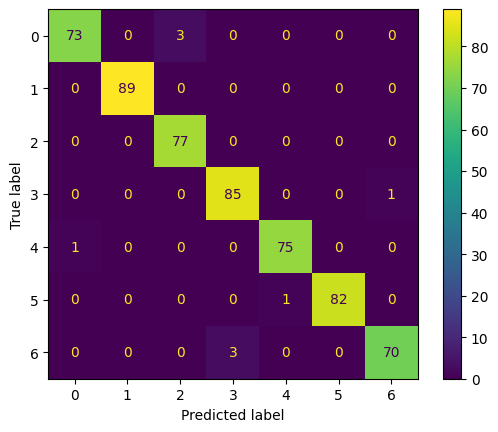

Training and Evaluating GaussianNB
GaussianNBAccuracy: 0.8928571428571429
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        76
           1       0.94      0.94      0.94        89
           2       0.94      1.00      0.97        77
           3       0.70      0.95      0.81        86
           4       0.93      0.99      0.96        76
           5       0.96      0.86      0.90        83
           6       0.91      0.58      0.71        73

    accuracy                           0.89       560
   macro avg       0.91      0.89      0.89       560
weighted avg       0.91      0.89      0.89       560



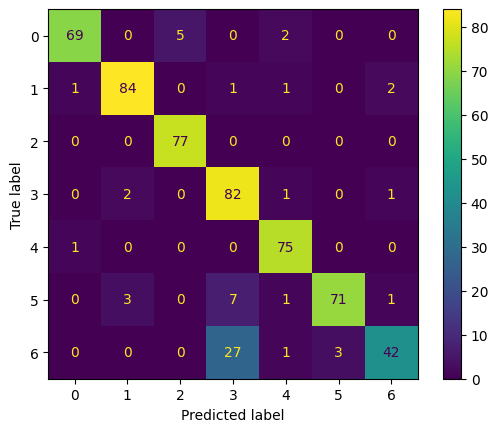

Training and Evaluating LogisticRegression
LogisticRegressionAccuracy: 0.8964285714285715
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        76
           1       0.88      0.87      0.87        89
           2       0.93      0.96      0.94        77
           3       0.84      0.87      0.86        86
           4       0.97      0.93      0.95        76
           5       0.92      0.87      0.89        83
           6       0.88      0.86      0.87        73

    accuracy                           0.90       560
   macro avg       0.90      0.90      0.90       560
weighted avg       0.90      0.90      0.90       560



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


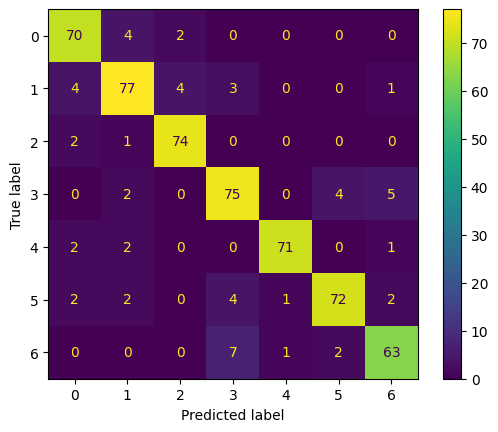

Training and Evaluating SVM-sigmoid
SVM-sigmoidAccuracy: 0.18035714285714285
              precision    recall  f1-score   support

           0       0.18      0.12      0.14        76
           1       0.50      0.08      0.14        89
           2       0.19      0.56      0.28        77
           3       0.23      0.22      0.23        86
           4       0.12      0.30      0.18        76
           5       0.00      0.00      0.00        83
           6       0.00      0.00      0.00        73

    accuracy                           0.18       560
   macro avg       0.18      0.18      0.14       560
weighted avg       0.18      0.18      0.14       560



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


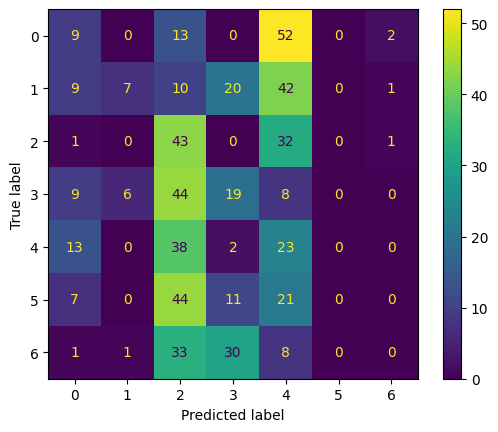

Training and Evaluating SVM-rbf
SVM-rbfAccuracy: 0.7214285714285714
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        76
           1       0.50      0.80      0.62        89
           2       0.85      0.97      0.91        77
           3       0.67      0.55      0.60        86
           4       0.69      0.95      0.80        76
           5       0.96      0.65      0.78        83
           6       0.82      0.38      0.52        73

    accuracy                           0.72       560
   macro avg       0.77      0.72      0.72       560
weighted avg       0.76      0.72      0.72       560



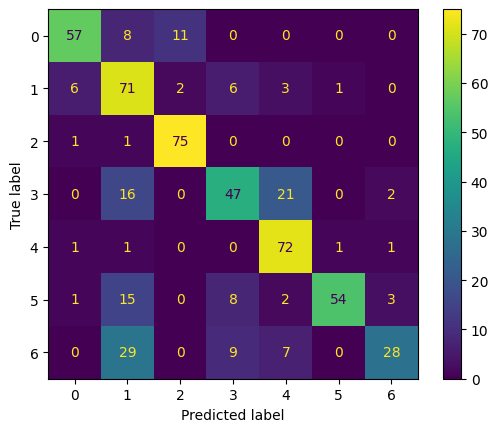

Training and Evaluating SVM-linear
SVM-linearAccuracy: 0.9482142857142857
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        76
           1       0.94      0.98      0.96        89
           2       1.00      1.00      1.00        77
           3       0.88      0.92      0.90        86
           4       0.96      0.97      0.97        76
           5       0.96      0.92      0.94        83
           6       0.95      0.86      0.91        73

    accuracy                           0.95       560
   macro avg       0.95      0.95      0.95       560
weighted avg       0.95      0.95      0.95       560



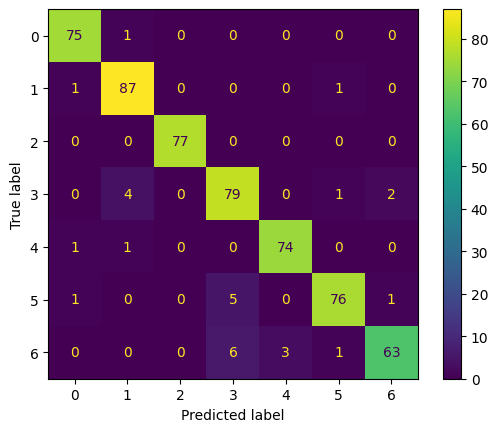

Training and Evaluating LGBMClassifier
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2240, number of used features: 20
[LightGBM] [Info] Start training from score -1.933488
[LightGBM] [Info] Start training from score -1.974438
[LightGBM] [Info] Start training from score -1.936579
[LightGBM] [Info] Start training from score -1.964838
[LightGBM] [Info] Start training from score -1.933488
[LightGBM] [Info] Start training from score -1.955329
[LightGBM] [Info] Start training from score -1.924271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

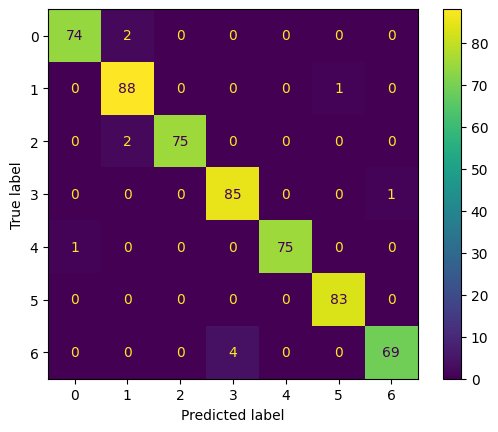

Training and Evaluating XGBClassifier
XGBClassifierAccuracy: 0.975
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        76
           1       0.98      0.99      0.98        89
           2       0.96      0.99      0.97        77
           3       0.96      0.99      0.97        86
           4       0.97      0.96      0.97        76
           5       1.00      0.99      0.99        83
           6       0.97      0.96      0.97        73

    accuracy                           0.97       560
   macro avg       0.98      0.97      0.97       560
weighted avg       0.98      0.97      0.97       560



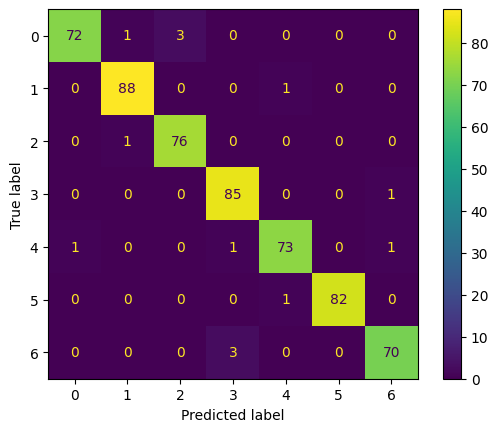

Training and Evaluating GradientBoostingClassifier
GradientBoostingClassifierAccuracy: 0.9714285714285714
              precision    recall  f1-score   support

           0       0.99      0.93      0.96        76
           1       0.95      1.00      0.97        89
           2       0.96      0.99      0.97        77
           3       0.95      1.00      0.97        86
           4       0.99      0.95      0.97        76
           5       1.00      0.98      0.99        83
           6       0.99      0.95      0.97        73

    accuracy                           0.97       560
   macro avg       0.97      0.97      0.97       560
weighted avg       0.97      0.97      0.97       560



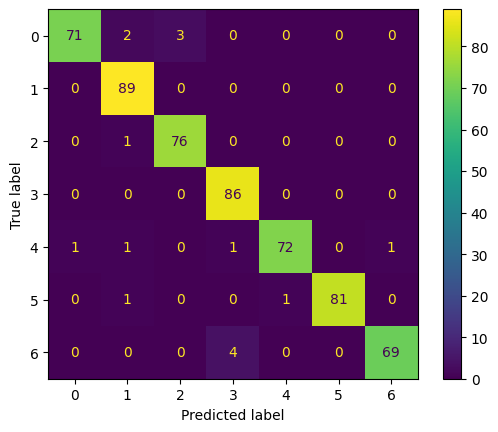

In [26]:
for clf_name,clf in classifiers.items():
  print(f"Training and Evaluating {clf_name}")
  clf.fit(X_train,y_train)
  y_pred=clf.predict(X_test)
  print(f"{clf_name}Accuracy: {accuracy_score(y_test,y_pred)}")
  print(classification_report(y_test,y_pred))
  cm=confusion_matrix(y_test,y_pred)
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
  disp.plot()
  plt.show()